# Structured Names
This notebook describes how to use structured names to check SBML models for moiety balance.

In [1]:
import init
from SBMLLint.common import constants as cn
from SBMLLint.common.molecule import Molecule
from SBMLLint.common import simple_sbml
from SBMLLint.common.reaction import Reaction
from SBMLLint.tools import sbmllint
from SBMLLint.tools import print_reactions
from SBMLLint.common.simple_sbml import SimpleSBML

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

In [2]:
from SBMLLint.common.simple_sbml import modelIterator

In [3]:
iterator = modelIterator(initial=19, final=25)
for item in iterator:
    print(item.filename)

BIOMD0000000241_url.xml
BIOMD0000000350_url.xml
MODEL0847712949_url.xml
BIOMD0000000346_url.xml
BIOMD0000000256_url.xml
BIOMD0000000402_url.xml


In [4]:
import init
from SBMLLint.tools import sbmllint

# The first step in glycolysis, expressed
# in the Antimony language.
model = """
Glu + A__P_3 -> Glu_P + A_P_P; 1
Glu = 0
A_P_P_P = 0
Glu_P = 0
A_P_P = 0
"""
_ = sbmllint.lint(model)


0 of 1 reactions have imbalances.



In [5]:
# The first step in glycolysis, with an error (wrongly goes to A instead of A_P_P)
model = """
Glu + A_P_P_P -> Glu_P + A_P; 1
"""
_ = sbmllint.lint(model)


1 of 1 reactions have imbalances.

***_J0: Glu + A_P_P_P -> Glu_P + A_P
Excess moieties in reactants
  P: 1.00




In [7]:
cn.ANALYSIS_STRUCTURED_NAMES_DIR

'/home/ubuntu/SBMLLint/analysis/structured_names'

## Sturctured Names in BioModels

In [8]:
path = os.path.join(cn.ANALYSIS_STRUCTURED_NAMES_DIR, "analyze_structured_names.csv")
df_data = pd.read_csv(path)
df_data.head()

,filename,is_structured,num_boundary_reactions,total_reactions,num_imbalanced_reactions,num_balanced_reactions,frac_balanced_reactions,frac_Boundary_reactions
0,BIOMD0000000100_url.xml,False,5,10,10,0,0.0,0.500000
1,BIOMD0000000355_url.xml,True,12,17,17,0,0.0,0.705882
2,BIOMD0000000413_url.xml,False,4,9,9,0,0.0,0.444444
3,BIOMD0000000594_url.xml,True,0,120,120,0,0.0,0.000000
4,BIOMD0000000354_url.xml,False,6,11,11,0,0.0,0.545455


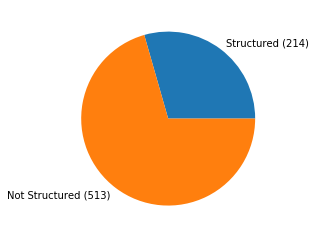

In [9]:
# Basic Statistics
num_structured = len(df_data[df_data[cn.IS_STRUCTURED]])
num_not_structured = len(df_data) - num_structured
_ = plt.pie([num_structured, num_not_structured], 
            labels=["Structured (%d)" % num_structured, "Not Structured (%d)" % num_not_structured])

Text(0, 0.5, 'Fraction of Models')

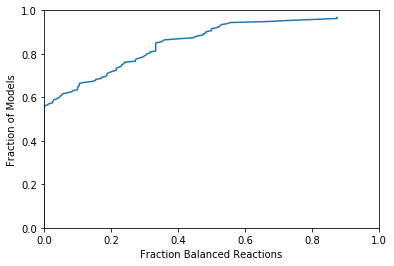

In [10]:
df_sort = df_data[df_data[cn.IS_STRUCTURED]]
df_sort = df_sort.sort_values(cn.FRAC_BALANCED_REACTIONS)
df_sort = df_sort.reset_index()
yv = [1.0*i/len(df_sort) for i in df_sort.index]
_ = plt.plot(df_sort[cn.FRAC_BALANCED_REACTIONS], yv)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Fraction Balanced Reactions")
plt.ylabel("Fraction of Models")

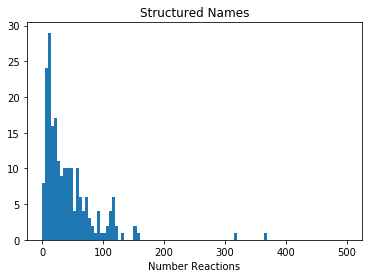

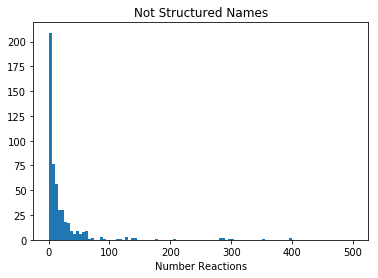

In [11]:
def plotIsStructured(df, val):
    df1 = df[df[cn.IS_STRUCTURED] == val]
    plt.hist(df1[cn.TOTAL_REACTIONS], bins=100, range=(0, 500))
    if val:
        title = "Structured Names"
    else:
        title = "Not Structured Names"
    plt.title(title)
    plt.xlabel("Number Reactions")
    plt.show()
plotIsStructured(df_data, True)
plotIsStructured(df_data, False)

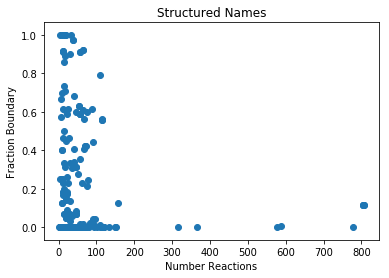

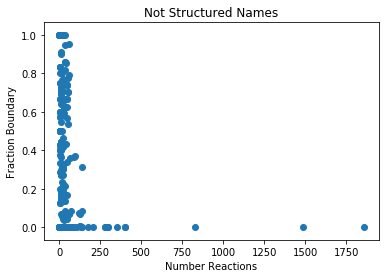

In [12]:
def plotFrcBoundary(df, val):
    df1 = df[df[cn.IS_STRUCTURED] == val]
    plt.scatter(df1[cn.TOTAL_REACTIONS], df1[cn.FRAC_BOUNDARY_REACTIONS])
    if val:
        title = "Structured Names"
    else:
        title = "Not Structured Names"
    plt.title(title)
    plt.xlabel("Number Reactions")
    plt.ylabel("Fraction Boundary")
    plt.show()
plotFrcBoundary(df_data, True)
plotFrcBoundary(df_data, False)

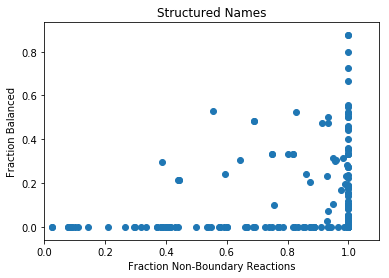

In [13]:
def plotFracBalanced(df):
    df1 = df[df[cn.IS_STRUCTURED]]
    xv = (1.0*df1[cn.TOTAL_REACTIONS] - df1[cn.NUM_BOUNDARY_REACTIONS]) / df1[cn.TOTAL_REACTIONS]
    plt.scatter(xv, df1[cn.FRAC_BALANCED_REACTIONS])
    title = "Structured Names"
    plt.title(title)
    plt.xlabel("Fraction Non-Boundary Reactions")
    plt.ylabel("Fraction Balanced")
    plt.xlim([0, 1.1])
    plt.show()
plotFracBalanced(df_data)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning:

invalid value encountered in greater_equal

/home/ubuntu/miniconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning:

invalid value encountered in less_equal



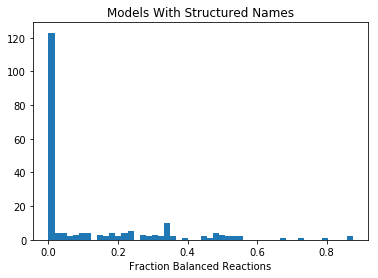

In [14]:
# Histogram of fraction balanced for structured names
def plotFracBalancedHist(df):
    df1 = df[df[cn.IS_STRUCTURED]]
    plt.hist(df1[cn.FRAC_BALANCED_REACTIONS], bins=50)
    title = "Models With Structured Names"
    plt.title(title)
    plt.xlabel("Fraction Balanced Reactions")
    plt.show()
plotFracBalancedHist(df_data)

## Detailed Look at Putative Structured Names

**Observations**
1. Some cases where doing ad hoc structured names that with little change can balance. For example:   
   1. BIOMD0000000192_url.xml: RCC1_RanGDP -> RCC1_Ran + GDP, RCC1_Ran + GTP -> RCC1_RanGTP
   1. BIOMD0000000010_url.xml: MKKK -> MKKK_P, MKKK_P -> MKKK

In [17]:
df = df_data[df_data[cn.IS_STRUCTURED]]
for _, row in df.iterrows():
    path = os.path.join(cn.BIOMODELS_DIR, row[cn.FILENAME])
    try:
        print("\n%s" % row[cn.FILENAME])
        print_reactions.prettyPrint(path, is_include_kinetics=False, is_include_label=False)
    except:
        pass


BIOMD0000000355_url.xml
 -> IP3
CaI -> CaS
CaS -> CaI
IP3 -> 
 -> g
g -> 
 -> CaI
CaI -> 
 -> mwaf195932_a72c_4552_8cf2_b349b15d39c4
mwaf195932_a72c_4552_8cf2_b349b15d39c4 -> 
 -> mw0ebc76ad_49d7_4845_8f88_04d443fbe7f3
 -> mw7cb2644a_384a_4bbb_93fd_fd686e01d7cb
mw7cb2644a_384a_4bbb_93fd_fd686e01d7cb -> 
mw0ebc76ad_49d7_4845_8f88_04d443fbe7f3 -> 
CaI -> mw013a7c64_a9ec_483c_b3b8_ed658337ee95
CaS -> mw013a7c64_a9ec_483c_b3b8_ed658337ee95
mw013a7c64_a9ec_483c_b3b8_ed658337ee95 -> CaI

BIOMD0000000594_url.xml
EGFR_10UU -> EGFR_00UU
EGFR_01UU -> EGFR_00UU
EGFR_11UU -> EGFR_01UU
EGFR_11UU -> EGFR_10UU
EGFR_11CU -> EGFR_10CU
EGFR_11LU -> EGFR_10LU
EGFR_11UG -> EGFR_01UG
EGFR_11UL -> EGFR_01UL
EGFR_02UU -> EGFR_01UU
EGFR_02UG -> EGFR_01UG
EGFR_02UL -> EGFR_01UL
EGFR_12UU -> EGFR_02UU
EGFR_12UU -> EGFR_11UU
EGFR_12CU -> EGFR_11CU
EGFR_12LU -> EGFR_11LU
EGFR_12UG -> EGFR_02UG
EGFR_12UG -> EGFR_11UG
EGFR_12UL -> EGFR_02UL
EGFR_12UL -> EGFR_11UL
EGFR_12CG -> EGFR_11CG
EGFR_12CC -> EGFR_11CC
EGFR_

 -> cL_m
cL_m -> 
 -> cL
cL -> 
 -> cLm
cLm -> 
 -> cP
cP -> 
 -> cP9_m
cP9_m -> 
 -> cP9
cP9 -> 
 -> cP7_m
cP7_m -> 
 -> cP7
cP7 -> 
 -> cNI_m
cNI_m -> 
 -> cNI
cNI -> 
 -> cT_m
cT_m -> 
 -> cT
cT -> 
 -> cE4_m
cE4_m -> 
 -> cE4
cE4 -> 
 -> cE3_m
cE3_m -> 
 -> cE3
cE3 -> 
cE3 -> cE3n
cE3n -> 
 -> cLUX_m
cLUX_m -> 
 -> cLUX
cLUX -> 
 -> cCOP1c
cCOP1c -> 
cCOP1c -> cCOP1n
cCOP1n -> 
cCOP1n -> cCOP1d
cCOP1d -> 
 -> cG_m
cG_m -> 
 -> cG
cG -> 
cG + cZTL -> cZG
 -> cZTL
cZTL -> 
cZG -> 
cE3 + cG -> cEG
cEG -> 
 -> cEC
cEC -> 

BIOMD0000000236_url.xml
GLC -> G6P_F6P
G6P_F6P -> FBP
FBP -> 2.00 DHAP_G3P
DHAP_G3P -> 

BIOMD0000000090_url.xml
sul_ex -> sul
eth_ex -> eth
sul + A3c -> aps + PPi
oxy_ex -> oxy
oxy -> oxy_ex
aps + A3c -> pap + A2c
pap + 3.00 N2 -> hyd + 3.00 N1
hyd + oah -> cys
cys -> 
eth + 2.00 N1 -> aco + 2.00 N2
aco -> oah
hyd -> 
oah -> 
S2 + aco -> S1
S1 + 4.00 N1 -> S2 + 4.00 N2
C1 + Hm + N2 -> C2 + Ho + N1
C2 + oxy -> C1 + H2O
A2c + A3m -> A2m + A3c
Ho + A2m -> Hm + A3m
Ho -

mw30ae63db_6cd3_4b6f_93ad_3350cd360bcc + mwf626e95e_543f_41e4_aad4_c6bf60ab345b -> mw03db56ac_8dc6_4931_ae82_fef706d2ee3d
mw03db56ac_8dc6_4931_ae82_fef706d2ee3d + mwbbbce920_e8dd_4320_9386_fc94bfb2fc99 -> mw810ff751_fa4e_4143_bd50_169b3e325e1e
 -> mwf626e95e_543f_41e4_aad4_c6bf60ab345b
mwf626e95e_543f_41e4_aad4_c6bf60ab345b -> 
mw114aa90f_5f5b_4fe8_9406_361c8489b6a1 -> 
mw4638f126_8cb8_4021_ab41_6ae195743ba0 + mw80848184_e2dd_47ce_86d7_7a21479342bd -> mwd2d9d93a_3bd1_4f17_bac1_baba9ef2d55a
mw10315fa3_6f13_4618_bda8_a8694bd3c374 + mw0adf3eb4_a196_4c48_b10d_4e9e9faaf9e1 -> mw7d86cc23_a1af_44c3_bdb9_71e9b1bb2a83
mw7d86cc23_a1af_44c3_bdb9_71e9b1bb2a83 + mw80848184_e2dd_47ce_86d7_7a21479342bd -> mwd2d9d93a_3bd1_4f17_bac1_baba9ef2d55a
mwd2d9d93a_3bd1_4f17_bac1_baba9ef2d55a -> mw0eb6c959_d408_45a0_a450_928b8c5876bb
mw42054cd7_17af_46da_970c_7f99151906ad + mw0eb6c959_d408_45a0_a450_928b8c5876bb -> mw39c2e431_fdc3_4964_be29_6ca856620b1b + mw0eb6c959_d408_45a0_a450_928b8c5876bb
mw39c2e431_fdc3_4

ZF_blood -> ZF_airways
ZF_blood -> 
ML_intes -> ML_blood
ML_blood -> 

BIOMD0000000412_url.xml
s1 -> cL_m
cL_m -> s2
s3 -> cL
cL -> s4
s5 -> cLm
cLm -> s6
s7 -> cP
cP -> s8
s9 -> cP9_m
cP9_m -> s10
s11 -> cP9
cP9 -> s12
s13 -> cP7_m
cP7_m -> s14
s15 -> cP7
cP7 -> s16
s17 -> cNI_m
cNI_m -> s18
s19 -> cNI
cNI -> s20
s21 -> cT_m
cT_m -> s22
s23 -> cT
cT -> s24
s25 -> cE4_m
cE4_m -> s26
s27 -> cE4
cE4 -> s28
s29 -> cE3_m
cE3_m -> s30
s31 -> cE3
cE3 -> s32
cE3 -> cE3n
cE3n -> s33
s34 -> cLUX_m
cLUX_m -> s35
s36 -> cLUX
cLUX -> s37
s38 -> cCOP1c
cCOP1c -> s39
cCOP1c -> cCOP1n
cCOP1n -> s40
cCOP1n -> cCOP1d
cCOP1d -> s41
s42 -> cG_m
cG_m -> s43
s44 -> cG
cG -> s45
cG + cZTL -> cZG
s46 -> cZTL
cZTL -> s47
cZG -> s48
cE3 + cG -> cEG
cEG -> s49
s50 -> cEC
cEC -> s51

BIOMD0000000445_url.xml
 -> cL_m
cL_m -> 
 -> cL
cL -> 
 -> cLm
cLm -> 
 -> cP
cP -> 
 -> cP9_m
cP9_m -> 
 -> cP9
cP9 -> 
 -> cP7_m
cP7_m -> 
 -> cP7
cP7 -> 
 -> cNI_m
cNI_m -> 
 -> cNI
cNI -> 
 -> cT_m
cT_m -> 
 -> cT
cT -> 
 -> cE

time -> T
frq_gene -> frq_mRNA
wc1_gene -> wc1_mRNA
wc2_gene -> wc2_mRNA
vvd_gene -> vvd_mRNA
frq_mRNA -> hypoFRQc
wc1_mRNA -> WC1c
wc2_mRNA -> WC2c
vvd_mRNA -> VVDc
frq_mRNA -> degraded_frq_mRNA
wc1_mRNA -> degraded_wc1_mRNA
wc2_mRNA -> degraded_wc2_mRNA
vvd_mRNA -> degraded_vvd_mRNA
WC1c + WC2c -> hypoWCCc
hypoFRQc -> hypoFRQn
hypoWCCc -> hypoWCCn
VVDc -> VVDn
hypoFRQn -> hypoFRQc
hyperFRQn -> hyperFRQc
hyperWCCn -> hyperWCCc
hypoFRQc -> hyperFRQc
hypoFRQn -> hyperFRQn
hypoWCCc -> hyperWCCc
hypoWCCn -> hyperWCCn
hyperWCCc -> hypoWCCc
hypoWCCn -> active_hypoWCCn
hypoWCCn -> L_WCC
VVDn + L_WCC -> L_WCCVVDn
L_WCCVVDn -> hypoWCCn + VVDn
hyperFRQc -> degraded_hyperFRQc
hyperFRQn -> degraded_hyperFFCn
WC1c -> degraded_WC1c
WC2c -> degraded_WC2c
hyperWCCc -> degraded_hyperWCCc
hyperWCCn -> degraded_hyperWCCn
active_hypoWCCn -> degraded_active_hypoWCCn
L_WCC -> degraded_L_WCCCVVDn
VVDc -> degraded_VVDc
VVDn -> degraded_VVDn
L_WCCVVDn -> degraded_L_WCCCVVDn

MODEL0404023805_url.xml
R_cw0 -> R

mwe2fff28d_182c_4a1c_9882_f17774c0958a + mw93907b2d_53db_4080_9e3f_3eb304441ab9 -> mw7eacabf9_d68c_491a_aba2_ec0809a8ecc8
mw7eacabf9_d68c_491a_aba2_ec0809a8ecc8 + mw7eacabf9_d68c_491a_aba2_ec0809a8ecc8 -> mwa8f2e7b2_0927_4ab4_a817_dddc43bb4fa3
mwa8f2e7b2_0927_4ab4_a817_dddc43bb4fa3 -> mwbfcf6773_1915_432c_b1d2_1f246094cc74
mwbfcf6773_1915_432c_b1d2_1f246094cc74 + mw3c2e1b43_29ca_491a_93e9_c723a993d6fb -> mw5198d3c2_879c_4f0d_b4f8_cd40efe0b1cf
mwbfcf6773_1915_432c_b1d2_1f246094cc74 + mwe57c3282_5935_405c_8c0b_7fadb7a5de17 -> mw954e8fcb_ac0a_459d_8878_f19080208a17
mw5198d3c2_879c_4f0d_b4f8_cd40efe0b1cf -> mwa98802cb_c977_4fe0_9e67_5000904c2c36
mw954e8fcb_ac0a_459d_8878_f19080208a17 -> mwa8f2e7b2_0927_4ab4_a817_dddc43bb4fa3 + mwe57c3282_5935_405c_8c0b_7fadb7a5de17
mwa98802cb_c977_4fe0_9e67_5000904c2c36 -> mwbfcf6773_1915_432c_b1d2_1f246094cc74 + mwa0349407_8187_48fc_9e94_5698ccc4e06d
mwa0349407_8187_48fc_9e94_5698ccc4e06d + mwe57c3282_5935_405c_8c0b_7fadb7a5de17 -> mwf9999977_6f0e_4e35_9b

R_cw0 -> R_cw1
R_ccw0 -> R_ccw1
R_cw1 -> R_cw2
R_ccw1 -> R_ccw2
R_cw2 -> R_cw3
R_ccw2 -> R_ccw3
R_cw3 -> R_cw4
R_ccw3 -> R_ccw4
R_cw4 -> R_cw5
R_ccw4 -> R_ccw5
R_cw5 -> R_cw6
R_ccw5 -> R_ccw6
R_cw6 -> R_cw7
R_ccw6 -> R_ccw7
R_cw7 -> R_cw8
R_ccw7 -> R_ccw8
R_cw8 -> R_cw9
R_ccw8 -> R_ccw9
R_cw9 -> R_cw10
R_ccw9 -> R_ccw10
R_cw10 -> R_cw11
R_ccw10 -> R_ccw11
R_cw11 -> R_cw12
R_ccw11 -> R_ccw12
R_cw12 -> R_cw13
R_ccw12 -> R_ccw13
R_cw13 -> R_cw14
R_ccw13 -> R_ccw14
R_cw14 -> R_cw15
R_ccw14 -> R_ccw15
R_cw15 -> R_cw16
R_ccw15 -> R_ccw16
R_cw16 -> R_cw17
R_ccw16 -> R_ccw17
R_cw17 -> R_cw18
R_ccw17 -> R_ccw18
R_cw18 -> R_cw19
R_ccw18 -> R_ccw19
R_cw19 -> R_cw20
R_ccw19 -> R_ccw20
R_cw20 -> R_cw21
R_ccw20 -> R_ccw21
R_cw21 -> R_cw22
R_ccw21 -> R_ccw22
R_cw22 -> R_cw23
R_ccw22 -> R_ccw23
R_cw23 -> R_cw24
R_ccw23 -> R_ccw24
R_cw24 -> R_cw25
R_ccw24 -> R_ccw25
R_cw25 -> R_cw26
R_ccw25 -> R_ccw26
R_cw26 -> R_cw27
R_ccw26 -> R_ccw27
R_cw27 -> R_cw28
R_ccw27 -> R_ccw28
R_cw28 -> R_cw29
R_ccw28 -> R_

AA -> T1R_surf
T1R_surf -> T1R_endo
T1R_endo -> T1R_surf
T1R_endo -> empty_degraded
AA -> T2R_surf
T2R_surf -> T2R_endo
T2R_endo -> T2R_surf
T2R_endo -> empty_degraded
TGF_beta_ex + T2R_surf + T1R_surf -> LRC_surf
LRC_surf -> LRC_endo
LRC_endo -> empty_degraded
LRC_endo -> T1R_endo + T2R_endo + TGF_beta_endo
TGF_beta_endo -> empty_degraded
Smad2c -> Smad2n
Smad2n -> Smad2c
Smad4c -> Smad4n
Smad4n -> Smad4c
Smad2c -> PSmad2c
PSmad2c -> PSmad2n
PSmad2n -> PSmad2c
PSmad2c + Smad4c -> PSmad2_Smad4_c
PSmad2_Smad4_c -> PSmad2_Smad4_n
PSmad2_Smad4_n -> PSmad2n + Smad4n
PSmad2n -> Smad2n
2.00 PSmad2c -> PSmad2_PSmad2_c
PSmad2_PSmad2_c -> PSmad2_PSmad2_n
PSmad2_PSmad2_n -> 2.00 PSmad2n
LRC_surf -> empty_degraded
TGF_beta_ex -> TGF_beta_ns

BIOMD0000000235_url.xml
PRE_E_Gcad -> mRNA_E_Gcad
PRE_E_Notch -> mRNA_E_Notch
PRE_E_Otx -> mRNA_E_Otx
PRE_E_SoxB1 -> mRNA_E_SoxB1
PRE_E_SuH -> mRNA_E_SuH
PRE_E_UMR -> mRNA_E_UMR
PRE_E_UVAOtx -> mRNA_E_UVAOtx
PRE_E_UbiqSoxB1 -> mRNA_E_UbiqSoxB1
PRE_E_VEGF -> m

M_trp_DASH_L_c + M_h2o_c + M_o2_c -> M_indpyr_c + M_nh4_c + M_h2o2_c
M_trp_DASH_L_c + M_o2_c -> M_Lfmkynr_c
M_trp_DASH_L_c -> M_trypta_c + M_co2_c
M_Lkynr_c + M_h2o_c -> M_anth_c + M_ala_DASH_L_c
M_thbpt + M_trp_DASH_L_c + M_o2_c -> M_5htrp_c + M_dhbpt_c + M_h2o_c
M_Lkynr_c + M_akg_c -> M_kynate_c + M_glu_DASH_L_c
M_Lfmkynr_c + M_h2o_c -> M_for_c + M_Lkynr_c
M_Lkynr_c + M_o2_c + M_nadph_c + M_h_c -> M_hLkynr_c + M_nadp_c + M_h2o_c
M_amet_c + M_trypta_c -> M_ahcys_c + M_nmtrpta_c
M_3hanthrn_c + M_o2_c -> M_cmusa_c
M_hLkynr_c + M_h2o_c -> M_3hanthrn_c + M_ala_DASH_L_c
M_5htrp_c -> M_srtn_c + M_co2_c
M_5htrp_c + M_o2_c -> M_5hoxnfkyn_c
M_atp_c + M_trp_DASH_L_c + M_trna_trp_c -> M_amp_c + M_ppi_c + M_trp_L_trna_c
M_5hoxnfkyn_c + M_h2o_c -> M_5hxkyn_c + M_for_c
M_cmusa_c -> M_quln_c
M_trypta_c + M_h2o_c + M_o2_c -> M_id3acald_c + M_nh4_c + M_h2o2_c
2.00 M_3hanthrn_c + 4.00 M_o2_c -> M_Cinnavalininate_c + 2.00 M_o2s_c + 2.00 M_h2o2_c + 2.00 M_h_c
TRP_ex -> M_trp_DASH_L_c
M_trp_DASH_L_c + M_o

R_cw0 -> R_cw1
R_ccw0 -> R_ccw1
R_cw1 -> R_cw2
R_ccw1 -> R_ccw2
R_cw2 -> R_cw3
R_ccw2 -> R_ccw3
R_cw3 -> R_cw4
R_ccw3 -> R_ccw4
R_cw4 -> R_cw5
R_ccw4 -> R_ccw5
R_cw5 -> R_cw6
R_ccw5 -> R_ccw6
R_cw6 -> R_cw7
R_ccw6 -> R_ccw7
R_cw7 -> R_cw8
R_ccw7 -> R_ccw8
R_cw8 -> R_cw9
R_ccw8 -> R_ccw9
R_cw9 -> R_cw10
R_ccw9 -> R_ccw10
R_cw10 -> R_cw11
R_ccw10 -> R_ccw11
R_cw11 -> R_cw12
R_ccw11 -> R_ccw12
R_cw12 -> R_cw13
R_ccw12 -> R_ccw13
R_cw13 -> R_cw14
R_ccw13 -> R_ccw14
R_cw14 -> R_cw15
R_ccw14 -> R_ccw15
R_cw15 -> R_cw16
R_ccw15 -> R_ccw16
R_cw16 -> R_cw17
R_ccw16 -> R_ccw17
R_cw17 -> R_cw18
R_ccw17 -> R_ccw18
R_cw18 -> R_cw19
R_ccw18 -> R_ccw19
R_cw19 -> R_cw20
R_ccw19 -> R_ccw20
R_cw20 -> R_cw21
R_ccw20 -> R_ccw21
R_cw21 -> R_cw22
R_ccw21 -> R_ccw22
R_cw22 -> R_cw23
R_ccw22 -> R_ccw23
R_cw23 -> R_cw24
R_ccw23 -> R_ccw24
R_cw24 -> R_cw25
R_ccw24 -> R_ccw25
R_cw25 -> R_cw26
R_ccw25 -> R_ccw26
R_cw26 -> R_cw27
R_ccw26 -> R_ccw27
R_cw27 -> R_cw28
R_ccw27 -> R_ccw28
R_cw28 -> R_cw29
R_ccw28 -> R_

rbp + cam_RR_0_0 -> cam_RR_0_rbp
tbp + cam_RR_0_0 -> cam_RR_0_tbp
ca + cam_RR_0_0 -> cam_RR_A_0
rbp + cam_RR_A_0 -> cam_RR_A_rbp
ca + cam_RR_0_rbp -> cam_RR_A_rbp
tbp + cam_RR_A_0 -> cam_RR_A_tbp
ca + cam_RR_0_tbp -> cam_RR_A_tbp
ca + cam_RR_0_0 -> cam_RR_B_0
rbp + cam_RR_B_0 -> cam_RR_B_rbp
ca + cam_RR_0_rbp -> cam_RR_B_rbp
tbp + cam_RR_B_0 -> cam_RR_B_tbp
ca + cam_RR_0_tbp -> cam_RR_B_tbp
ca + cam_RR_0_0 -> cam_RR_C_0
rbp + cam_RR_C_0 -> cam_RR_C_rbp
ca + cam_RR_0_rbp -> cam_RR_C_rbp
tbp + cam_RR_C_0 -> cam_RR_C_tbp
ca + cam_RR_0_tbp -> cam_RR_C_tbp
ca + cam_RR_0_0 -> cam_RR_D_0
rbp + cam_RR_D_0 -> cam_RR_D_rbp
ca + cam_RR_0_rbp -> cam_RR_D_rbp
tbp + cam_RR_D_0 -> cam_RR_D_tbp
ca + cam_RR_0_tbp -> cam_RR_D_tbp
ca + cam_RR_B_0 -> cam_RR_AB_0
ca + cam_RR_A_0 -> cam_RR_AB_0
rbp + cam_RR_AB_0 -> cam_RR_AB_rbp
ca + cam_RR_B_rbp -> cam_RR_AB_rbp
ca + cam_RR_A_rbp -> cam_RR_AB_rbp
tbp + cam_RR_AB_0 -> cam_RR_AB_tbp
ca + cam_RR_B_tbp -> cam_RR_AB_tbp
ca + cam_RR_A_tbp -> cam_RR_AB_tbp
ca + c

stat_sol -> stat_nuc

BIOMD0000000452_url.xml
mwe2fff28d_182c_4a1c_9882_f17774c0958a + mw93907b2d_53db_4080_9e3f_3eb304441ab9 -> mw7eacabf9_d68c_491a_aba2_ec0809a8ecc8
mw7eacabf9_d68c_491a_aba2_ec0809a8ecc8 + mw7eacabf9_d68c_491a_aba2_ec0809a8ecc8 -> mwa8f2e7b2_0927_4ab4_a817_dddc43bb4fa3
mwa8f2e7b2_0927_4ab4_a817_dddc43bb4fa3 -> mwbfcf6773_1915_432c_b1d2_1f246094cc74
mwbfcf6773_1915_432c_b1d2_1f246094cc74 + mw3c2e1b43_29ca_491a_93e9_c723a993d6fb -> mw5198d3c2_879c_4f0d_b4f8_cd40efe0b1cf
mwbfcf6773_1915_432c_b1d2_1f246094cc74 + mwe57c3282_5935_405c_8c0b_7fadb7a5de17 -> mw954e8fcb_ac0a_459d_8878_f19080208a17
mw5198d3c2_879c_4f0d_b4f8_cd40efe0b1cf -> mwa98802cb_c977_4fe0_9e67_5000904c2c36
mw954e8fcb_ac0a_459d_8878_f19080208a17 -> mwa8f2e7b2_0927_4ab4_a817_dddc43bb4fa3 + mwe57c3282_5935_405c_8c0b_7fadb7a5de17
mwa98802cb_c977_4fe0_9e67_5000904c2c36 -> mwbfcf6773_1915_432c_b1d2_1f246094cc74 + mwa0349407_8187_48fc_9e94_5698ccc4e06d
mwa0349407_8187_48fc_9e94_5698ccc4e06d + mwe57c3282_5935_405

R_cw0 -> R_cw1
R_ccw0 -> R_ccw1
R_cw1 -> R_cw2
R_ccw1 -> R_ccw2
R_cw2 -> R_cw3
R_ccw2 -> R_ccw3
R_cw3 -> R_cw4
R_ccw3 -> R_ccw4
R_cw4 -> R_cw5
R_ccw4 -> R_ccw5
R_cw5 -> R_cw6
R_ccw5 -> R_ccw6
R_cw6 -> R_cw7
R_ccw6 -> R_ccw7
R_cw7 -> R_cw8
R_ccw7 -> R_ccw8
R_cw8 -> R_cw9
R_ccw8 -> R_ccw9
R_cw9 -> R_cw10
R_ccw9 -> R_ccw10
R_cw10 -> R_cw11
R_ccw10 -> R_ccw11
R_cw11 -> R_cw12
R_ccw11 -> R_ccw12
R_cw12 -> R_cw13
R_ccw12 -> R_ccw13
R_cw13 -> R_cw14
R_ccw13 -> R_ccw14
R_cw14 -> R_cw15
R_ccw14 -> R_ccw15
R_cw15 -> R_cw16
R_ccw15 -> R_ccw16
R_cw16 -> R_cw17
R_ccw16 -> R_ccw17
R_cw17 -> R_cw18
R_ccw17 -> R_ccw18
R_cw18 -> R_cw19
R_ccw18 -> R_ccw19
R_cw19 -> R_cw20
R_ccw19 -> R_ccw20
R_cw20 -> R_cw21
R_ccw20 -> R_ccw21
R_cw21 -> R_cw22
R_ccw21 -> R_ccw22
R_cw22 -> R_cw23
R_ccw22 -> R_ccw23
R_cw23 -> R_cw24
R_ccw23 -> R_ccw24
R_cw24 -> R_cw25
R_ccw24 -> R_ccw25
R_cw25 -> R_cw26
R_ccw25 -> R_ccw26
R_cw26 -> R_cw27
R_ccw26 -> R_ccw27
R_cw27 -> R_cw28
R_ccw27 -> R_ccw28
R_cw28 -> R_cw29
R_ccw28 -> R_

R_cw0 -> R_cw1
R_ccw0 -> R_ccw1
R_cw1 -> R_cw2
R_ccw1 -> R_ccw2
R_cw2 -> R_cw3
R_ccw2 -> R_ccw3
R_cw3 -> R_cw4
R_ccw3 -> R_ccw4
R_cw4 -> R_cw5
R_ccw4 -> R_ccw5
R_cw5 -> R_cw6
R_ccw5 -> R_ccw6
R_cw6 -> R_cw7
R_ccw6 -> R_ccw7
R_cw7 -> R_cw8
R_ccw7 -> R_ccw8
R_cw8 -> R_cw9
R_ccw8 -> R_ccw9
R_cw9 -> R_cw10
R_ccw9 -> R_ccw10
R_cw10 -> R_cw11
R_ccw10 -> R_ccw11
R_cw11 -> R_cw12
R_ccw11 -> R_ccw12
R_cw12 -> R_cw13
R_ccw12 -> R_ccw13
R_cw13 -> R_cw14
R_ccw13 -> R_ccw14
R_cw14 -> R_cw15
R_ccw14 -> R_ccw15
R_cw15 -> R_cw16
R_ccw15 -> R_ccw16
R_cw16 -> R_cw17
R_ccw16 -> R_ccw17
R_cw17 -> R_cw18
R_ccw17 -> R_ccw18
R_cw18 -> R_cw19
R_ccw18 -> R_ccw19
R_cw19 -> R_cw20
R_ccw19 -> R_ccw20
R_cw20 -> R_cw21
R_ccw20 -> R_ccw21
R_cw21 -> R_cw22
R_ccw21 -> R_ccw22
R_cw22 -> R_cw23
R_ccw22 -> R_ccw23
R_cw23 -> R_cw24
R_ccw23 -> R_ccw24
R_cw24 -> R_cw25
R_ccw24 -> R_ccw25
R_cw25 -> R_cw26
R_ccw25 -> R_ccw26
R_cw26 -> R_cw27
R_ccw26 -> R_ccw27
R_cw27 -> R_cw28
R_ccw27 -> R_ccw28
R_cw28 -> R_cw29
R_ccw28 -> R_

II_f + 100.00 LIPID -> II_l
mIIa_f + 100.00 LIPID -> mIIa_l
V_f + 100.00 LIPID -> V_l
Va_f + 100.00 LIPID -> Va_l
VII_f + 100.00 LIPID -> VII_l
VIIa_f + 100.00 LIPID -> VIIa_l
X_f + 100.00 LIPID -> X_l
Xa_f + 100.00 LIPID -> Xa_l
APC_f + 100.00 LIPID -> APC_l
PS_f + 100.00 LIPID -> PS_l
Vai_f + 100.00 LIPID -> Vai_l
PC_f + 100.00 LIPID -> PC_l
VIIa_l + TF_l -> TF_VIIa_l
VII_l + TF_l -> TF_VII_l
X_l + TF_VIIa_l -> TF_VIIa_X_l
TF_VIIa_X_l -> TF_VIIa_Xa_l
TF_VIIa_Xa_l -> Xa_l + TF_VIIa_l
Xa_l + TF_VII_l -> TF_VII_Xa_l
TF_VII_Xa_l -> Xa_l + TF_VIIa_l
Va_l + Xa_l -> Xa_Va_l
Xa_l + V_l -> V_Xa_l
V_Xa_l -> Xa_l + Va_l
IIa_f + V_l -> V_IIa_l
V_IIa_l -> IIa_f + Va_l
II_l + Xa_Va_l -> Xa_Va_II_l
mIIa_l + Xa_Va_l -> Xa_Va_mIIa_l
Xa_Va_II_l -> Xa_Va_mIIa_l
Xa_Va_mIIa_l -> IIa_f + Xa_Va_l + 100.00 LIPID
Xa_l + VII_l -> VII_Xa_l
VII_Xa_l -> Xa_l + VIIa_l
Va_l + APC_PS_l -> APC_PS_Va_l
APC_PS_Va_l -> Vai_l + APC_PS_l
Xa_f + TFPI_f -> TFPI_Xa_l
TF_VIIa_l + TFPI_Xa_l -> TFPI_Xa_TF_VIIa_l
AT_f + Xa_f ->

mw0b46978f_b522_4cde_97f0_574cd7dbbae7 + mwbe974953_e869_4622_b4a8_745555c8d7fd -> mw6b2f1c44_e0be_4406_bcef_ad5061d519e4
mwdb9dc389_2bf0_4039_9f09_282f5511958b + mw351f6cee_3e64_4b8e_8e60_24b1aca99a92 -> mw6b2f1c44_e0be_4406_bcef_ad5061d519e4
mwe2fc02e6_2684_4071_932a_f7a8bd13b2fe + mw351f6cee_3e64_4b8e_8e60_24b1aca99a92 -> mw0b46978f_b522_4cde_97f0_574cd7dbbae7
mwe2fc02e6_2684_4071_932a_f7a8bd13b2fe + mwbe974953_e869_4622_b4a8_745555c8d7fd -> mwdb9dc389_2bf0_4039_9f09_282f5511958b
mwf82770b9_766a_4c4e_851a_d76da19e8517 + mwd8ea533a_c66e_4de4_8c5c_0d4201d8c8a2 -> mwd86ce0dc_7329_4b27_9de0_ee6bffee3083
mw9d5c5c9d_301d_4e43_ba7b_7d21ccbdc2c2 + mwd8ea533a_c66e_4de4_8c5c_0d4201d8c8a2 -> mwe4e36b8e_18b8_4c76_bd46_13614b71da5c
mw3e1a2fbf_37b1_490c_9528_6cb6bbf11b21 + mwd86ce0dc_7329_4b27_9de0_ee6bffee3083 -> mwe4e36b8e_18b8_4c76_bd46_13614b71da5c
mw3e1a2fbf_37b1_490c_9528_6cb6bbf11b21 + mwf82770b9_766a_4c4e_851a_d76da19e8517 -> mw9d5c5c9d_301d_4e43_ba7b_7d21ccbdc2c2
mw724f1afe_8032_40ae_96c

EpoRJAK2 -> EpoRpJAK2
EpoRpJAK2 -> EpoRJAK2
EpoRpJAK2 -> p1EpoRpJAK2
EpoRpJAK2 -> p2EpoRpJAK2
p1EpoRpJAK2 -> p12EpoRpJAK2
p2EpoRpJAK2 -> p12EpoRpJAK2
p1EpoRpJAK2 -> EpoRJAK2
p2EpoRpJAK2 -> EpoRJAK2
p12EpoRpJAK2 -> EpoRJAK2
EpoRJAK2_CIS -> 
SHP1 -> SHP1Act
SHP1Act -> SHP1
STAT5 -> pSTAT5
STAT5 -> pSTAT5
pSTAT5 -> npSTAT5
npSTAT5 -> STAT5
 -> CISnRNA1
CISnRNA1 -> CISnRNA2
CISnRNA2 -> CISnRNA3
CISnRNA3 -> CISnRNA4
CISnRNA4 -> CISnRNA5
CISnRNA5 -> CISRNA
CISRNA -> 
 -> CIS
CIS -> 
 -> CIS
 -> SOCS3nRNA1
SOCS3nRNA1 -> SOCS3nRNA2
SOCS3nRNA2 -> SOCS3nRNA3
SOCS3nRNA3 -> SOCS3nRNA4
SOCS3nRNA4 -> SOCS3nRNA5
SOCS3nRNA5 -> SOCS3RNA
SOCS3RNA -> 
 -> SOCS3
SOCS3 -> 
 -> SOCS3

BIOMD0000000269_url.xml
 -> Auxin
 -> Auxin
Auxin -> 
Ra -> Ra_star
Ra_star -> Ra
 -> PLSm
PLSm -> 
 -> PLSp
PLSp -> 
Re -> Re_star
Re_star -> Re
 -> ET
ET -> 
CTR1 -> CTR1_star
CTR1_star -> CTR1
 -> X
X -> 
 -> CK
CK -> 
ACC -> ET
IAA -> Auxin
CK_ex -> CK

BIOMD0000000202_url.xml
Ca_ER -> Ca_Cyt
Ca_Cyt -> Ca_ER
 -> Ca_Cyt
Ca_

DHAP_g -> GA3P_g
PEP_c + ADP_c -> Pyr_c + ATP_c
ATP_g + Fru6P_g -> Fru16BP_g + ADP_g
Glc6P_g + NADP_g -> _6PGL_g + NADPH_g
_3PGA_c -> _2PGA_c
Pyr_c -> Pyr_e
Glc6P_c + NADP_c -> NADPH_c + _6PGL_c
_2PGA_c -> PEP_c
ATP_g + Glc_g -> Glc6P_g + ADP_g
ADP_g + Rib5P_g -> ATP_g + Rib_g
_3PGA_g -> _3PGA_c
NADPH_c -> NADP_c
Glc_c + ATP_c -> Glc6P_c + ADP_c
NADPH_g -> NADP_g
Fru_g + ATP_g -> ADP_g + Fru6P_g
Glc6P_c -> Glc_c
2.00 ADP_c -> AMP_c + ATP_c
Glc6P_g -> Fru6P_g
Fru_c + ATP_c -> ADP_c + Fru6P_c
TSH2_c -> TS2_c
Gly3P_g + DHAP_c -> Gly3P_c + DHAP_g
Fru_c -> Fru_g
_6PGL_c -> _6PG_c
Fru_e -> Fru_c
2.00 ADP_g -> AMP_g + ATP_g
NADP_c + _6PG_c -> CO2_c + NADPH_c + Rul5P_c
Rul5P_c -> Rib5P_c
Rul5P_g -> Rib5P_g
_6PG_g + NADP_g -> Rul5P_g + CO2_g + NADPH_g
Glc_c -> Glc_g
Glc_e -> Glc_c
_6PGL_g -> _6PG_g
TS2_c + NADPH_c -> NADP_c + TSH2_c
_13BPGA_g + ADP_g -> _3PGA_g + ATP_g
NADH_g + DHAP_g -> Gly3P_g + NAD_g
ATP_c -> ADP_c
Gly3P_g + ADP_g -> Gly_e + ATP_g
Fru16BP_g -> GA3P_g + DHAP_g
GA3P_g + NAD_g 

DHAP_g -> GA3P_g
PEP_c + ADP_c -> Pyr_c + ATP_c
ATP_g + Fru6P_g -> Fru16BP_g + ADP_g
Glc6P_g + NADP_g -> _6PGL_g + NADPH_g
_3PGA_c -> _2PGA_c
Pyr_c -> Pyr_e
Glc6P_c + NADP_c -> NADPH_c + _6PGL_c
_2PGA_c -> PEP_c
ATP_g + Glc_g -> Glc6P_g + ADP_g
_3PGA_g -> _3PGA_c
NADPH_c -> NADP_c
Glc_c + ATP_c -> Glc6P_c + ADP_c
NADPH_g -> NADP_g
2.00 ADP_c -> AMP_c + ATP_c
Glc6P_c -> Glc_c
_6PG_g + NADP_g -> Rul5P_g + CO2_g + NADPH_g
Glc6P_g -> Fru6P_g
2.00 ADP_g -> AMP_g + ATP_g
TSH2_c -> TS2_c
Gly3P_g + DHAP_c -> Gly3P_c + DHAP_g
ADP_g + ATP_c -> ATP_g + ADP_c
_6PGL_c -> _6PG_c
NADP_c + _6PG_c -> CO2_c + NADPH_c + Rul5P_c
Rul5P_c -> Rib5P_c
Rul5P_g -> Rib5P_g
Glc_c -> Glc_g
Glc_e -> Glc_c
_6PGL_g -> _6PG_g
TS2_c + NADPH_c -> NADP_c + TSH2_c
_13BPGA_g + ADP_g -> _3PGA_g + ATP_g
NADH_g + DHAP_g -> Gly3P_g + NAD_g
ATP_c -> ADP_c
Gly3P_g + ADP_g -> Gly_e + ATP_g
Fru16BP_g -> GA3P_g + DHAP_g
GA3P_g + NAD_g + Pi_g -> NADH_g + _13BPGA_g
Gly3P_c -> DHAP_c

BIOMD0000000239_url.xml
 -> GLC
LAC -> 
GAP -> 
GL

Source -> NatP
NatP + ROS -> MisP + ROS + totMisP
MisP -> NatP + refNatP
MisP + E3 -> E3_MisP
E3_MisP -> MisP + E3
E1 + Ub + ATP -> E1_Ub + AMP
E2 + E1_Ub -> E2_Ub + E1
E2_Ub + E3_MisP -> MisP_Ub + E2 + E3
MisP_Ub + E2_Ub -> MisP_Ub2 + E2
MisP_Ub2 + E2_Ub -> MisP_Ub3 + E2
MisP_Ub3 + E2_Ub -> MisP_Ub4 + E2
MisP_Ub4 + E2_Ub -> MisP_Ub5 + E2
MisP_Ub5 + E2_Ub -> MisP_Ub6 + E2
MisP_Ub6 + E2_Ub -> MisP_Ub7 + E2
MisP_Ub7 + E2_Ub -> MisP_Ub8 + E2
MisP_Ub8 + DUB -> MisP_Ub7 + DUB + Ub
MisP_Ub7 + DUB -> MisP_Ub6 + DUB + Ub
MisP_Ub6 + DUB -> MisP_Ub5 + DUB + Ub
MisP_Ub5 + DUB -> MisP_Ub4 + DUB + Ub
MisP_Ub4 + DUB -> MisP_Ub3 + DUB + Ub
MisP_Ub3 + DUB -> MisP_Ub2 + DUB + Ub
MisP_Ub2 + DUB -> MisP_Ub + DUB + Ub
MisP_Ub + DUB -> MisP + DUB + Ub
MisP_Ub4 + Proteasome -> MisP_Ub4_Proteasome
MisP_Ub5 + Proteasome -> MisP_Ub5_Proteasome
MisP_Ub6 + Proteasome -> MisP_Ub6_Proteasome
MisP_Ub7 + Proteasome -> MisP_Ub7_Proteasome
MisP_Ub8 + Proteasome -> MisP_Ub8_Proteasome
MisP_Ub8_Proteasome + DUB -> MisP_

Source -> Ub
Ub + Proteasome -> Proteasome
MisP -> MisP + 3.00 Ub + 3.00 upregUb
Source -> NatP
NatP + ROS -> MisP + ROS
MisP -> NatP
MisP + E3 -> E3_MisP
E3_MisP -> MisP + E3
E1 + Ub + ATP -> E1_Ub + AMP
E2 + E1_Ub -> E2_Ub + E1
E2_Ub + E3_MisP -> E3_MisP_Ub + E2
E3_MisP_Ub + E2_Ub -> E3_MisP_Ub2 + E2
E3_MisP_Ub2 + E2_Ub -> E3_MisP_Ub3 + E2
E3_MisP_Ub3 + E2_Ub -> E3_MisP_Ub4 + E2
E3_MisP_Ub4 + E2_Ub -> E3_MisP_Ub5 + E2
E3_MisP_Ub5 + E2_Ub -> E3_MisP_Ub6 + E2
E3_MisP_Ub6 + E2_Ub -> E3_MisP_Ub7 + E2
E3_MisP_Ub7 + E2_Ub -> E3_MisP_Ub8 + E2
E3_MisP_Ub + DUB -> E3_MisP_Ub_DUB
E3_MisP_Ub2 + DUB -> E3_MisP_Ub2_DUB
E3_MisP_Ub3 + DUB -> E3_MisP_Ub3_DUB
E3_MisP_Ub4 + DUB -> E3_MisP_Ub4_DUB
E3_MisP_Ub5 + DUB -> E3_MisP_Ub5_DUB
E3_MisP_Ub6 + DUB -> E3_MisP_Ub6_DUB
E3_MisP_Ub7 + DUB -> E3_MisP_Ub7_DUB
E3_MisP_Ub8 + DUB -> E3_MisP_Ub8_DUB
E3_MisP_Ub8_DUB -> E3_MisP_Ub7_DUB + Ub
E3_MisP_Ub7_DUB -> E3_MisP_Ub6_DUB + Ub
E3_MisP_Ub6_DUB -> E3_MisP_Ub5_DUB + Ub
E3_MisP_Ub5_DUB -> E3_MisP_Ub4_DUB + Ub
E3

mwf82ad06a_b8aa_40fa_a532_a1da44e3425f -> NGFR + mwf82ad06a_b8aa_40fa_a532_a1da44e3425f
L_NGFR -> pTrkA
pTrkA -> pTrkA_endo
Shc_pTrkA -> Shc_pTrkA_endo
pShc_pTrkA -> pShc_pTrkA_endo
Grb2_SOS_pShc_pTrkA -> Grb2_SOS_pShc_pTrkA_endo
FRS2_pTrkA -> FRS2_pTrkA_endo
pFRS2_pTrkA -> pFRS2_pTrkA_endo
Crk_C3G_pFRS2_pTrkA -> Crk_C3G_pFRS2_pTrkA_endo
pTrkA_endo -> 
Shc_pTrkA_endo -> Shc
pShc_pTrkA_endo -> pShc
Grb2_SOS_pShc_pTrkA_endo -> Grb2_SOS_pShc
FRS2_pTrkA_endo -> FRS2
pFRS2_pTrkA_endo -> pFRS2
Crk_C3G_pFRS2_pTrkA_endo -> Crk_C3G + pFRS2
pTrkA + Shc -> Shc_pTrkA
pTrkA + pShc -> pShc_pTrkA
pTrkA + Grb2_SOS_pShc -> Grb2_SOS_pShc_pTrkA
pTrkA_endo + Shc -> Shc_pTrkA_endo
pTrkA_endo + pShc -> pShc_pTrkA_endo
pTrkA_endo + Grb2_SOS_pShc -> Grb2_SOS_pShc_pTrkA_endo
pTrkA + FRS2 -> FRS2_pTrkA
pTrkA + pFRS2 -> pFRS2_pTrkA
pTrkA_endo + FRS2 -> FRS2_pTrkA_endo
pTrkA_endo + pFRS2 -> pFRS2_pTrkA_endo
Shc_pTrkA -> pShc_pTrkA
Shc_pTrkA_endo -> pShc_pTrkA_endo
FRS2_pTrkA -> pFRS2_pTrkA
FRS2_pTrkA_endo -> pFRS

Caspase_I + Bax -> Caspase_A + Bax
Caspase_I + Beclin_I -> Caspase_A + Beclin_I
Caspase_I + p38_P -> Caspase_A + p38_P
Caspase_A -> Caspase_I
Caspase_A + Bcl2_Beclin -> Caspase_I + Bcl2_Beclin
Caspase_A + Bcl2 -> Caspase_I + Bcl2
Lys_I + Beclin -> Lys_A + Beclin
Lys_A -> Lys_I
Source -> Bcl2
Bcl2 -> Sink
Bcl2 + ROS -> Sink + ROS
Bcl2 + Caspase_A -> Sink + Caspase_A
Bax + Bcl2 -> Bax_Bcl2
Bax_Bcl2 -> Bax + Bcl2
Bcl2 + Beclin -> Bcl2_Beclin
Bcl2_Beclin -> Bcl2 + Beclin
Bcl2 + Beclin_I -> Bcl2_Beclin_I
Bcl2_Beclin_I -> Bcl2 + Beclin_I
Beclin -> Beclin_I
Beclin + Caspase_A -> Beclin_I + Caspase_A
Beclin + Bax_Bcl2 -> Bax_Bcl2_Beclin
Beclin_I + Bax_Bcl2 -> Bax_Bcl2_Beclin_I
Bax + Bcl2_Beclin -> Bax_Bcl2_Beclin
Bax + Bcl2_Beclin_I -> Bax_Bcl2_Beclin_I
Bax_Bcl2_Beclin -> Bax + Bcl2_Beclin
Bax_Bcl2_Beclin_I -> Bax + Bcl2_Beclin_I
Bax_Bcl2_Beclin -> Beclin + Bax_Bcl2
Bax_Bcl2_Beclin_I -> Beclin_I + Bax_Bcl2
Source -> ROS
ROS -> Sink
NatP + ROS -> DamP + ROS
DamP + Lys_A -> Lys_A
Source -> AGEpr

IXa_VIIIa + X -> IXa_VIIIa_X
IXa_VIIIa_X -> IXa_VIIIa + Xa
VIIIa -> VIIIa1_L + VIIIa2
IXa_VIIIa_X -> VIIIa1_L + VIIIa2 + X + IXa
IXa_VIIIa -> VIIIa1_L + VIIIa2 + IXa
IIa + V -> IIa + Va
Xa + Va -> Xa_Va
Xa_Va + II -> Xa_Va_II
Xa_Va_II -> Xa_Va + mIIa + mwbdb849d8_2b25_4551_8de8_adc8bead2303
mIIa + Xa_Va -> IIa + Xa_Va
Xa + TFPI -> Xa_TFPI
TF_VIIa_Xa + TFPI -> TF_VIIa_Xa_TFPI
TF_VIIa + Xa_TFPI -> TF_VIIa_Xa_TFPI
Xa + ATIII -> Xa_ATIII
mIIa + ATIII -> mIIa_ATIII
IXa + ATIII -> IXa_ATIII
IIa + ATIII -> IIa_ATIII
TF_VIIa + ATIII -> TF_VIIa_ATIII
mw4e2cf0b0_bd70_45a4_9e60_eba82fa5c3e4 + mw469042d3_a94f_4ebe_af1c_1ead580aad2a -> mw4e2cf0b0_bd70_45a4_9e60_eba82fa5c3e4 + mw6c404de5_5b24_48d6_a0c4_5491e07b1f72
mw6c404de5_5b24_48d6_a0c4_5491e07b1f72 + mw8c2b9a07_22c3_4912_adb1_167a38ea4cb3 -> mw819d0d09_05ba_4674_85ba_5c9439fb77f4
mw819d0d09_05ba_4674_85ba_5c9439fb77f4 -> mw6c404de5_5b24_48d6_a0c4_5491e07b1f72 + mw2be3652b_79af_4228_9d1c_9d65c7d0c70f
mw469042d3_a94f_4ebe_af1c_1ead580aad2a + mw2b

R6_G -> R6_G_GTP
R0_G_GTP -> G_GTP + R0
R1_G_GTP -> G_GTP + R1
R2_G_GTP -> G_GTP + R2
R3_G_GTP -> G_GTP + R3
R4_G_GTP -> G_GTP + R4
R5_G_GTP -> G_GTP + R5
R6_G_GTP -> G_GTP + R6
G_GTP -> Ga_GTP + Gbg
Ga_GTP + PDE -> PDE_Ga_GTP
PDE_Ga_GTP -> PDE_a_Ga_GTP
Ga_GTP + PDE_a_Ga_GTP -> Ga_GTP_PDE_a_Ga_GTP
Ga_GTP_PDE_a_Ga_GTP -> Ga_GTP_a_PDE_a_Ga_GTP
Ga_GTP_a_PDE_a_Ga_GTP + RGS -> RGS_Ga_GTP_a_PDE_a_Ga_GTP
RGS_Ga_GTP_a_PDE_a_Ga_GTP -> Ga_GDP + PDE_a_Ga_GTP + RGS
PDE_a_Ga_GTP + RGS -> RGS_PDE_a_Ga_GTP
RGS_PDE_a_Ga_GTP -> Ga_GDP + PDE + RGS
PDE_a_Ga_GTP -> Ga_GDP + PDE
Ga_GTP_a_PDE_a_Ga_GTP -> Ga_GDP + PDE_a_Ga_GTP
Ga_GTP -> Ga_GDP
Ga_GDP + Gbg -> Gt
RK -> Rec_wCa2_RK
Ca2_free -> Ca2_buff
Ca2_free -> 
 -> Ca2_free
 -> cGMP
cGMP -> 

BIOMD0000000578_url.xml
R -> R0
R_Gt -> R0_Gt
R0 + RK -> R0_RKpre
R1 + RK -> R1_RKpre
R2 + RK -> R2_RKpre
R3 + RK -> R3_RKpre
R4 + RK -> R4_RKpre
R5 + RK -> R5_RKpre
R6 + RK -> R6_RKpre
R0_RKpre -> R1_RKpost
R1_RKpre -> R2_RKpost
R2_RKpre -> R3_RKpost
R3_RKpre -> R4_R

pro_EGFR -> EGFR
EGF + EGFR -> L_EGFR
2.00 L_EGFR -> L_EGFR_dimer
SOS + Grb2 -> SOS_Grb2
Grb2 + pSOS -> pSOS_Grb2
L_EGFR_dimer -> L_dpEGFR
L_dpEGFR + c_Cbl -> dpEGFR_c_Cbl
L_dpEGFR + pShc -> pShc_dpEGFR
pDok -> Dok
c_Cbl + pShc_dpEGFR -> pShc_dpEGFR_c_Cbl
pSOS -> SOS
pSOS_Grb2 -> SOS_Grb2
L_dpEGFR + Shc -> Shc_dpEGFR
Shc_dpEGFR -> pShc_dpEGFR
dpEGFR_c_Cbl -> dpEGFR_c_Cbl_ubiq
dpEGFR_c_Cbl_ubiq -> proteosome + c_Cbl
c_Cbl + Shc_dpEGFR -> Shc_dpEGFR_c_Cbl
Shc_dpEGFR_c_Cbl -> Shc_dpEGFR_c_Cbl_ubiq
Shc_dpEGFR_c_Cbl_ubiq -> proteosome + c_Cbl + Shc
pShc_dpEGFR_c_Cbl -> pShc_dpEGFR_c_Cbl_ubiq
pShc_dpEGFR_c_Cbl_ubiq -> proteosome + c_Cbl + pShc
Shc_dpEGFR_c_Cbl -> pShc_dpEGFR_c_Cbl
pShc + SOS_Grb2 -> Grb2_SOS_pShc
L_dpEGFR + Grb2_SOS_pShc -> Grb2_SOS_pShc_dpEGFR
pShc_dpEGFR + SOS_Grb2 -> Grb2_SOS_pShc_dpEGFR
c_Cbl + Grb2_SOS_pShc_dpEGFR -> Grb2_SOS_pShc_dpEGFR_c_Cbl
dpEGFR_c_Cbl + Grb2_SOS_pShc -> Grb2_SOS_pShc_dpEGFR_c_Cbl
Grb2_SOS_pShc_dpEGFR_c_Cbl -> Grb2_SOS_pShc_dpEGFR_c_Cbl_ubiq
Grb2_SO

JAK + R -> RJ
RJ + IFN -> IFNRJ
2.00 IFNRJ -> IFNRJ2
IFNRJ2 -> IFNRJ2_star
IFNRJ2_star + STAT1c -> IFNRJ2_star_STAT1c
IFNRJ2_star_STAT1c -> STAT1c_star + IFNRJ2_star
STAT1c_star + IFNRJ2_star -> IFNRJ2_star_STAT1c_star
2.00 STAT1c_star -> STAT1c_star_STAT1c_star
SHP2 + IFNRJ2_star -> IFNRJ2_star_SHP2
IFNRJ2_star_SHP2 -> SHP2 + IFNRJ2
STAT1c_star + PPX -> STAT1c_star_PPX
STAT1c_star_PPX -> STAT1c + PPX
STAT1c_star_STAT1c_star + PPX -> STAT1c_star_STAT1c_star_PPX
STAT1c_star_STAT1c_star_PPX -> STAT1c_STAT1c_star + PPX
STAT1c_star + STAT1c -> STAT1c_STAT1c_star
STAT1c_star_STAT1c_star -> STAT1n_star_STAT1n_star
2.00 STAT1n_star -> STAT1n_star_STAT1n_star
STAT1n_star + PPN -> STAT1n_star_PPN
STAT1n_star_PPN -> STAT1n + PPN
STAT1n_star_STAT1n_star + PPN -> STAT1n_star_STAT1n_star_PPN
STAT1n_star_STAT1n_star_PPN -> STAT1n_STAT1n_star + PPN
STAT1n_star + STAT1n -> STAT1n_STAT1n_star
STAT1n -> STAT1c
 -> mRNAn
mRNAn -> mRNAc
 -> SOCS1
mRNAc -> 
SOCS1 -> 
IFNRJ2_star + SOCS1 -> IFNRJ2_star_SOCS

CRP + cAMP -> CRP_cAMP
CRP_cAMP + CRPsite_cyaA -> CRP_cAMP_CRPsite_cyaA
CRP_cAMP + CRPsiteI_crp -> CRP_cAMP_CRPsiteI_crp
CRP_cAMP + CRPsiteII_crp -> CRP_cAMP_CRPsiteII_crp
CRP_cAMP + CRPsite_ptsGp1 -> CRP_cAMP_CRPsite_ptsGp1
CRP_cAMP + CRPsite_ptsGp2 -> CRP_cAMP_CRPsite_ptsGp2
CRP_cAMP + CRPsite_ptsHp0 -> CRP_cAMP_CRPsite_ptsHp0
CRP_cAMP + CRPsite_ptsHp1 -> CRP_cAMP_CRPsite_ptsHp1
CRP_cAMP + CRPsite_ptsIp0 -> CRP_cAMP_CRPsite_ptsIp0
CRP_cAMP + CRPsite_ptsIp1 -> CRP_cAMP_CRPsite_ptsIp1
CRP_cAMP + CRPsite_mlcp1 -> CRP_cAMP_CRPsite_mlcp1
CRP_cAMP + CRPsite_mlcp2 -> CRP_cAMP_CRPsite_mlcp2
CRP_cAMP + CRPsite_genome -> CRP_cAMP_CRPsite_genome
Mlc + Mlcsite_ptsGp1 -> Mlc_Mlcsite_ptsGp1
Mlc + Mlcsite_ptsGp2 -> Mlc_Mlcsite_ptsGp2
Mlc + Mlcsite_ptsHp0 -> Mlc_Mlcsite_ptsHp0
Mlc + Mlcsite_ptsIp0 -> Mlc_Mlcsite_ptsIp0
Mlc + Mlcsite_mlcp1 -> Mlc_Mlcsite_mlcp1
Mlc + Mlcsite_mlcp2 -> Mlc_Mlcsite_mlcp2
IICB + Mlc -> IICB_Mlc
CYA + IIA_P -> IIA_P_CYA
 -> mRNA_cyaA
 -> mRNA_cyaA
 -> mRNA_crp
 -> mRNA_crp

In [ ]:
simple = SimpleSBML()
path = os.path.join(cn.DATA_DIR, "BIOMD0000000353_url.xml")
simple.initialize(path)

**To Do**
1. Identify the missing files. Likely a problem with the iterator?